In [1]:
import mlrfit as mf

import random
import numpy as np

from typing import List
import timeit

import seaborn as sns
import matplotlib.pyplot as plt

import scipy
import pypardiso

/Users/parshakova.tanya/opt/anaconda3/envs/routing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(1001)
random.seed(1001)

In [4]:
from time import perf_counter

def timer(f,*args):   
    start = perf_counter()
    f(*args)
    return (perf_counter() - start)

def run_repreat_func(func, repeats=1000):
    def repeat_func(*args):
        for _ in range(repeats):
            func(*args)
    return repeat_func

repeats = 1000

# Matvec operation

In [6]:
times = {'np_d':[], 'np_s':[]}
ratios = []

In [7]:
ns = [1000, 2000, 5000, 8000, 10000, 16000, 1000, 2000, 5000, 8000, 10000, 16000]
rs = [16]*(len(ns)//2) + [50]*(len(ns)//2) 

In [6]:
for n, rank in zip(ns, rs):
    x = np.random.randn(n, 1)
    m = n
    hpart = mf.random_hpartition(n,  n)
    num_levels = len(hpart['rows']['lk'])
    ranks = mf.uniform_capped_ranks(rank, hpart)
    # print(f"{ranks=}")
    hat_A = mf.MLRMatrix(hpart=hpart, ranks=ranks)
    hat_A.construct_sparse_format()
    hat_A_val = hat_A.matrix()

    np_d = timer(run_repreat_func(np.matmul), hat_A_val, x)*1000./repeats
    times['np_d'] += [np_d]
    A_size = 1.*hat_A_val.size

    assert np.allclose(hat_A.matvec(x), np.matmul(hat_A_val, x))
    np_s = timer(run_repreat_func(hat_A.matvec), x)*1000./repeats
    times['np_s'] += [np_s]
    sp_size = hat_A.tilde_B.nnz + hat_A.tilde_Ct.nnz
    sp_flops = 2*rank*(n + m) - rank - m
    ratios += [m * ( 2*n - 1) * 1.0 / sp_flops]

    print(f"{n=:6d}, {np_d=:3.4f}ms, {np_s=:3.4f}ms, sparsity_ratio={A_size/sp_size:.0f}")
    del hat_A, hat_A_val

n=  1000, np_d=0.1320ms, np_s=0.0795ms, sparsity_ratio=31
n=  2000, np_d=0.9468ms, np_s=0.1255ms, sparsity_ratio=62
n=  5000, np_d=9.6241ms, np_s=0.3580ms, sparsity_ratio=156
n=  8000, np_d=26.6097ms, np_s=0.5116ms, sparsity_ratio=250
n= 10000, np_d=42.3435ms, np_s=0.5734ms, sparsity_ratio=312
n= 16000, np_d=108.1744ms, np_s=0.9110ms, sparsity_ratio=500
n=  1000, np_d=0.1458ms, np_s=0.1598ms, sparsity_ratio=10
n=  2000, np_d=0.8414ms, np_s=0.2814ms, sparsity_ratio=20
n=  5000, np_d=11.2895ms, np_s=0.7453ms, sparsity_ratio=50
n=  8000, np_d=27.7961ms, np_s=1.2333ms, sparsity_ratio=80
n= 10000, np_d=41.9273ms, np_s=1.5871ms, sparsity_ratio=100
n= 16000, np_d=103.9378ms, np_s=2.4417ms, sparsity_ratio=160


In [7]:
time_ratios = np.divide(np.array(times['np_d']),  np.array(times['np_s']))
size_ratios = np.array(ratios)
idx = np.argsort(size_ratios)
time_ratios = time_ratios[idx]
size_ratios = size_ratios[idx]
size_ratios / time_ratios

array([11.01631788,  6.72209305, 19.11967009,  3.31741333,  8.416481  ,
        3.56721912,  3.80428361,  5.90378632,  3.77756678,  4.88226667,
        4.29916137,  4.27752657])

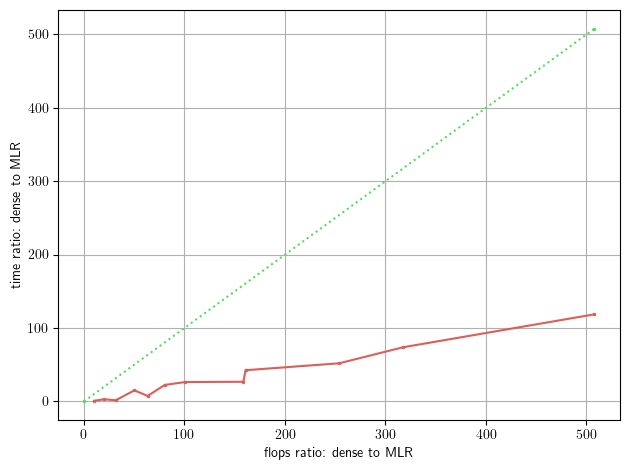

In [8]:
lw = 1
plt.rcParams['text.usetex'] = True
cmp = sns.color_palette("hls", 2+1)
fig, ax = plt.subplots(1, 1, dpi=100)
ax.plot(size_ratios, time_ratios, marker='.', markersize=3, label='time ratio', color=cmp[0])
ax.plot([0, size_ratios[-1]], [0, size_ratios[-1]], marker='.', markersize=3, label='size ratio', ls=':', color=cmp[1])     
for i in [0]:
    # ax.set_yscale('log')
    ax.grid(True)
    ax.set_xlabel("flops ratio: dense to MLR")
    # ax.legend()
ax.set_ylabel('time ratio: dense to MLR')
fig.tight_layout()
plt.show()

# Matrix vector product

In [9]:
for (m, n, rank) in [(1000, 1000, 50), (2000, 2000, 50), (5000, 5000, 50), (8000, 8000, 50), (16000, 16000, 50)]:
    print(f"\n{m=}, {n=}, {rank=}, storage_ratio={ m * n * 1.0 / ((m+n)*rank)}")
    x = np.random.randn(n, 1)
    hpart = mf.random_hpartition(m,  n)
    num_levels = len(hpart['rows']['lk'])
    ranks = mf.uniform_capped_ranks(rank, hpart)
    # print(f"{ranks=}")
    hat_A = mf.MLRMatrix(hpart=hpart, ranks=ranks)
    hat_A.construct_sparse_format()
    hat_A_val = hat_A.matrix()

    assert np.allclose(hat_A.matvec(x), np.matmul(hat_A_val, x))

    %timeit np.matmul(hat_A_val, x)
    %timeit hat_A.matvec(x)
    
    del hat_A, hat_A_val


m=1000, n=1000, rank=50, storage_ratio=10.0
96.6 µs ± 1.93 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
152 µs ± 758 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)

m=2000, n=2000, rank=50, storage_ratio=20.0
617 µs ± 5.71 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
279 µs ± 1.09 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

m=5000, n=5000, rank=50, storage_ratio=50.0
10.2 ms ± 346 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
725 µs ± 3.79 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

m=8000, n=8000, rank=50, storage_ratio=80.0
26.3 ms ± 510 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.17 ms ± 4.01 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

m=16000, n=16000, rank=50, storage_ratio=160.0
108 ms ± 2.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.47 ms ± 108 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Least squares

In [10]:
for (m, n, rank) in [(1000, 1000, 50), (2000, 2000, 50), (5000, 5000, 50), (7000, 7000, 50)]:
    m += 500
    print(f"\n{m=}, {n=}, {rank=}, storage_ratio={ m * n * 1.0 / ((m+n)*rank)}")
    x = np.random.randn(n, 1)
    hpart = mf.random_hpartition(m,  n)
    num_levels = len(hpart['rows']['lk'])
    ranks = mf.uniform_capped_ranks(rank, hpart)
    # print(f"{ranks=}")
    hat_A = mf.MLRMatrix(hpart=hpart, ranks=ranks)
    hat_A.construct_sparse_format()
    hat_A_val = hat_A.matrix()

    b = np.random.randn(m, 1)
    
    try:
        assert np.allclose((hat_A_val.T @ hat_A_val @ hat_A.lstsq(b)).flatten(), \
                       (hat_A_val.T @ b).flatten())
    except:
        print(mf.rel_diff(hat_A_val.T @ hat_A_val @ hat_A.lstsq(b).flatten(), \
                       (hat_A_val.T @ b).flatten()))
    
    print("dense matrix ls time:")
    %timeit np.linalg.lstsq(hat_A_val, b)[0]
    print("sparse matrix ls time:")
    %timeit hat_A.lstsq(b)
    
    del hat_A, hat_A_val


m=1500, n=1000, rank=50, storage_ratio=12.0
dense matrix ls time:


<magic-timeit>:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


241 ms ± 17.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
sparse matrix ls time:
2.55 ms ± 60.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

m=2500, n=2000, rank=50, storage_ratio=22.22222222222222
dense matrix ls time:
1.67 s ± 8.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
sparse matrix ls time:
4.27 ms ± 30.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

m=5500, n=5000, rank=50, storage_ratio=52.38095238095238
1.906722107474433e-06
dense matrix ls time:
26.3 s ± 1.23 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
sparse matrix ls time:
10.8 ms ± 1.81 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)

m=7500, n=7000, rank=50, storage_ratio=72.41379310344827
8.26590646926477e-08
dense matrix ls time:
1min 22s ± 2.1 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
sparse matrix ls time:
13.9 ms ± 133 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [3]:
# factor of speed gain
[np.round(a,1) for a in [241/2.55, 1.67/0.00427, 26.3/0.0108, (60+22)/0.0139]]

[94.5, 391.1, 2435.2, 5899.3]

# Linear system solve $Ax=b$ vs $\tilde B \tilde C^T x = b$

In [14]:
for (m, n, rank) in [(1000, 1000, 50), (2000, 2000, 50), (5000, 5000, 50), (8000, 8000, 50), (10000, 10000, 50), (16000, 16000, 50)]:
    
    print(f"\n{m=}, {n=}, {rank=}, storage_ratio={ m * n * 1.0 / ((m+n)*rank)}")
    x = np.random.randn(n, 1)
    hpart = mf.random_hpartition(n,  n)
    num_levels = len(hpart['rows']['lk'])
    ranks = mf.uniform_capped_ranks(rank, hpart)
    # print(f"{ranks=}")
    hat_A = mf.MLRMatrix(hpart=hpart, ranks=ranks)
    hat_A.construct_sparse_format()
    hat_A_val = hat_A.matrix()

    b = np.random.randn(m, 1)
    try:
        assert np.allclose(b.flatten(), (hat_A_val @ np.linalg.solve(hat_A_val, b)).flatten() )
        assert np.allclose((hat_A_val @ hat_A.solve(b)).flatten(), b.flatten())
    except:
        print(mf.rel_diff(b.flatten(), (hat_A_val @ np.linalg.solve(hat_A_val, b)).flatten() ))
        print(mf.rel_diff((hat_A_val @ hat_A.solve(b)).flatten(), b.flatten()))

    print("dense matrix solve time:")
    %timeit np.linalg.solve(hat_A_val, b)
    print("sparse matrix solve time:")
    %timeit hat_A.solve(b)

    del hat_A, hat_A_val


m=1000, n=1000, rank=50, storage_ratio=10.0
dense matrix solve time:
9.23 ms ± 598 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
sparse matrix solve time:
800 µs ± 24.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

m=2000, n=2000, rank=50, storage_ratio=20.0
dense matrix solve time:
64.1 ms ± 5.62 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
sparse matrix solve time:
1.63 ms ± 15.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

m=5000, n=5000, rank=50, storage_ratio=50.0
dense matrix solve time:
793 ms ± 7.59 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
sparse matrix solve time:
3.95 ms ± 58.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

m=8000, n=8000, rank=50, storage_ratio=80.0
dense matrix solve time:
3.06 s ± 161 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
sparse matrix solve time:
6.61 ms ± 636 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

m=10000, n=10000, rank=50, storage_ratio=100.0
d

In [4]:
# factor of speed gain
[np.round(a,1) for a in [9.23/0.8, 64.1/1.63, 793/3.95, 3.06/0.00661, 5.7/0.00813, 22.4/0.0138]]

[11.5, 39.3, 200.8, 462.9, 701.1, 1623.2]